In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

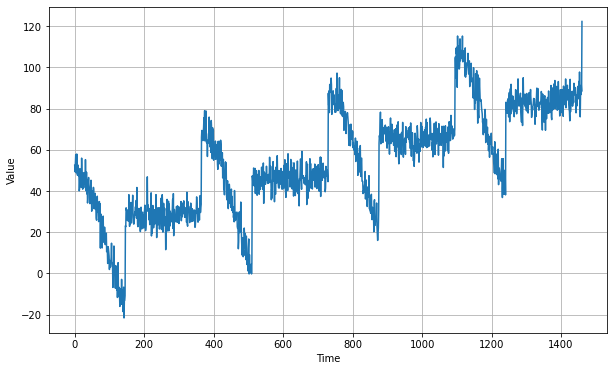

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4, 
                   np.cos(season_time * 2 * np.pi), 
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_label=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
sereis = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:])) # sequence to vector
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 27ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 25ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 1s 24ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 1s 24ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 1s 25ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 1s 24ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 1s 24ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

(1e-08, 0.0001, 0.0, 30.0)

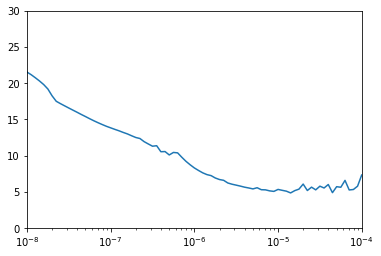

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", # Why Huber -> MSE???
             optimizer=optimizer,
             metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 36ms/step - loss: 1150.1854 - mae: 28.4029
Epoch 2/500
8/8 [==============================] - 0s 31ms/step - loss: 415.3719 - mae: 16.8050
Epoch 3/500
8/8 [==============================] - 0s 32ms/step - loss: 290.5741 - mae: 14.0827
Epoch 4/500
8/8 [==============================] - 0s 29ms/step - loss: 155.9039 - mae: 9.7255
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 110.9444 - mae: 7.6950
Epoch 6/500
8/8 [==============================] - 0s 36ms/step - loss: 80.5115 - mae: 6.3107
Epoch 7/500
8/8 [==============================] - 0s 30ms/step - loss: 118.5873 - mae: 8.6887
Epoch 8/500
8/8 [==============================] - 0s 35ms/step - loss: 91.4352 - mae: 7.1728
Epoch 9/500
8/8 [==============================] - 0s 32ms/step - loss: 76.4647 - mae: 6.4202
Epoch 10/500
8/8 [==============================] - 0s 32ms/step - loss: 64.1402 - mae: 5.8189
Epoch 11/500
8/8 [==============================]

8/8 [==============================] - 0s 33ms/step - loss: 48.4780 - mae: 5.2781
Epoch 173/500
8/8 [==============================] - 0s 33ms/step - loss: 44.1566 - mae: 4.9613
Epoch 174/500
8/8 [==============================] - 0s 32ms/step - loss: 42.3110 - mae: 4.8850
Epoch 175/500
8/8 [==============================] - 0s 31ms/step - loss: 41.7908 - mae: 4.8621
Epoch 176/500
8/8 [==============================] - 0s 32ms/step - loss: 42.5050 - mae: 4.8819
Epoch 177/500
8/8 [==============================] - 0s 30ms/step - loss: 41.0190 - mae: 4.7737
Epoch 178/500
8/8 [==============================] - 0s 29ms/step - loss: 47.5684 - mae: 5.3011
Epoch 179/500
8/8 [==============================] - 0s 31ms/step - loss: 46.3010 - mae: 5.1857
Epoch 180/500
8/8 [==============================] - 0s 33ms/step - loss: 44.0133 - mae: 4.9711
Epoch 181/500
8/8 [==============================] - 0s 34ms/step - loss: 47.7054 - mae: 5.1930
Epoch 182/500
8/8 [==============================] - 0

8/8 [==============================] - 0s 33ms/step - loss: 41.9556 - mae: 4.9097
Epoch 343/500
8/8 [==============================] - 0s 31ms/step - loss: 44.5507 - mae: 5.0658
Epoch 344/500
8/8 [==============================] - 0s 30ms/step - loss: 52.6811 - mae: 5.5182
Epoch 345/500
8/8 [==============================] - 0s 31ms/step - loss: 45.3546 - mae: 5.0594
Epoch 346/500
8/8 [==============================] - 0s 32ms/step - loss: 41.5330 - mae: 4.9181
Epoch 347/500
8/8 [==============================] - 0s 31ms/step - loss: 49.5444 - mae: 5.3712
Epoch 348/500
8/8 [==============================] - 0s 30ms/step - loss: 45.7583 - mae: 5.1401
Epoch 349/500
8/8 [==============================] - 0s 30ms/step - loss: 43.7584 - mae: 4.9830
Epoch 350/500
8/8 [==============================] - 0s 30ms/step - loss: 45.1547 - mae: 5.1117
Epoch 351/500
8/8 [==============================] - 0s 32ms/step - loss: 48.3041 - mae: 5.3771
Epoch 352/500
8/8 [==============================] - 0

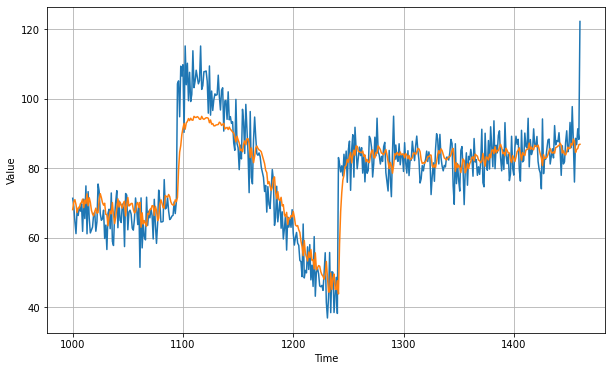

In [22]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.476913

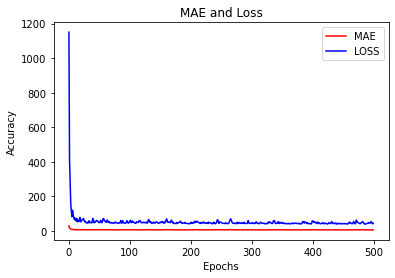

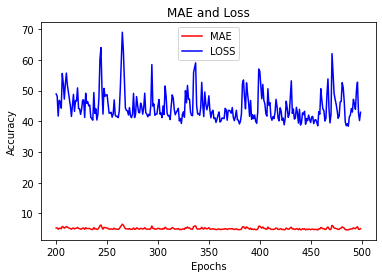

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
"""
Retrieve a list of list reults on training and test datasets for each training epoch
"""
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

"""
Plot MAE and Loss
"""
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "LOSS"])

plt.show()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

"""
Plot Zoomed MAE and Loss
"""
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "LOSS"])

plt.show()